# Introduction to Data Poisoning

Adversarial examples, which we will see in Notebook 2, fall within a category of attacks called evasion attacks. Evasion attacks happen at test time – a clean target instance is modified to avoid detection by a classifier, or spur misclassification.

Poison attacks happen at $\textit{training time}$; they aim to manipulate the performance of a system by inserting carefully constructed poison instances into the training data. Sometimes, a system can be poisoned with just a single data point, and this point won’t look suspicious, even to a trained observer.

The most common data poisoning attack type we observe is model skewing, where the attacker attempts to pollute training data in such a way that the boundary between what the classifier categorizes as one class, and what the classifier categorizes as another, shifts.

We will first explore this concept with the Fisher Iris dataset which is a multivariate data set introduced by the British statistician and biologist Ronald Fisher in his 1936 paper "The use of multiple measurements in taxonomic problems".  The data set consists of samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals of the flower, in centimeters. [Ref: https://en.wikipedia.org/wiki/Iris_flower_data_set]

In [1]:
#Load Dependencies

import sklearn
import pandas as pd
import matplotlib
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
# Look at the data

df = pd.read_csv('Data/iris.csv',index_col=0)
print(set(df['4']))
df.head()

set(['Iris-virginica', 'Iris-setosa', 'Iris-versicolor'])


,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
#Prepare the class labels. Iris setosa will be labelled as -1, Iris not setosa as 1

X = df.iloc[0:100, 4].values
y= np.where(X=="Iris-setosa", -1, 1)

We will retrict our attention to two classes within the dataset: setosa and not setosa. The two features we will include are petal length and septal length.

In [4]:
#Prepare the training data
data = df.iloc[0:100, [0,2]].values

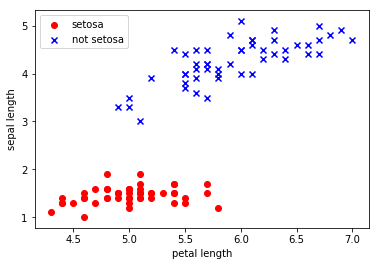

In [5]:
plt.scatter(data[:50, 0], data[:50, 1], color='red', marker='o', label='setosa')
plt.scatter(data[50:100, 0], data[50:100, 1], color='blue', marker='x', label='not setosa')
plt.xlabel('petal length')
plt.ylabel('sepal length')
plt.legend(loc='upper left')
plt.show()

In [6]:
def plot_decision_regions(data, y, clf, resolution=0.02):
    """
    A function that plots decision regions based on "Implementing a perceptron algorithm in Python by Raschka et al.
    """
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    #meshgrid
    x1min, x1max = data[:,0].min()-1, data[:, 0].max()+1
    x2min, x2max = data[:,1].min()-1, data[:,1].max()+1
    xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, resolution), np.arange(x2min, x2max, resolution))
    Z = clf.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=data[y==cl,0], y=data[y==cl, 1], 
                   alpha=0.8, c=cmap(idx), 
                   marker=markers[idx], label=cl)
    plt.scatter(x=[6.0], y=[1.8], 
               alpha=0.8, marker='v', c='cyan')


We will use a support vector machine (SVM) classifier and plot the decision boundary.

In [7]:
from sklearn import svm

clf = svm.LinearSVC()
clf.fit(data, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

The cyan marker on the plot indicates the region (petal length = 6cm, sepal length = 1.8 cm) where we would like the classifier to identify a data point as not setosa (c = 1)

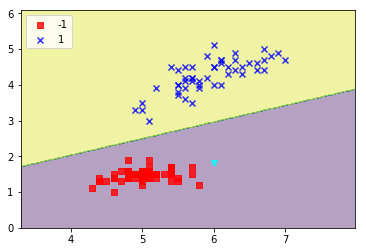

In [8]:
plot_decision_regions(data, y, clf)
plt.legend(loc='upper left')
plt.show()

We will now systemically inject new data points around the region with class label not setosa (c = 1) in order to shift the decision boundary of the SVM classifier.

In [9]:
def add_attack_point(data, y, attack_points, attack_class=1):
    """
    Add a new attack point to the dataset
    
    Returns:
    --------
    
    New dataset including attack point
    
    New class label vector including label for attacking class (1 in this case)
    """
    return np.concatenate((data, attack_points)), np.concatenate((y, np.array(len(attack_points)*[attack_class])))

def retrain_and_plot(clf, new_data, new_y):
    """
    Retrain the classifier with new data and plot the result
    """
    clf.fit(new_data, new_y)
    plot_decision_regions(new_data, new_y, clf)
    plt.legend(loc='upper left')
    plt.show()


In [10]:
new_data, new_labels = add_attack_point(data, y, [[6.0, 2.0]])

The new decision boundary differs very little.

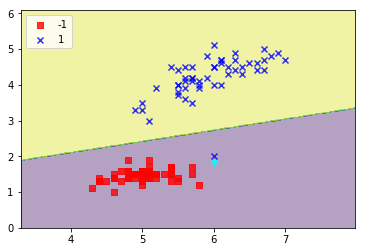

In [11]:
retrain_and_plot(clf, new_data, new_labels)

Let's add more around the targeted region!

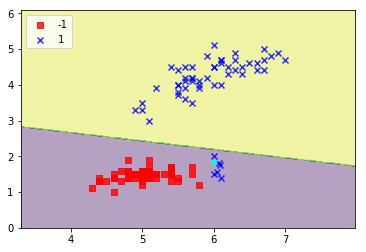

In [12]:
x1_new = [6.0, 6.1, 6.05, 6.08, 6.09]
x2_new = [1.5, 1.4, 1.55, 1.8, 1.75]
new_vals = map(list, zip(x1_new, x2_new))
new_data_2, new_labels_2 = add_attack_point(new_data, new_labels, new_vals)
retrain_and_plot(clf, new_data_2, new_labels_2)

We are getting close... maybe just a few more.

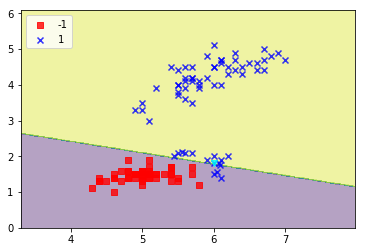

In [13]:
x1_new = [5.5, 5.6, 5.559, 5.7, 5.45, 6.0, 6.1, 6.2, 5.9]
x2_new = [2.1, 2.105, 2.110, 2.089, 2.0, 1.8, 1.9, 2.0, 1.9]
new_vals = map(list, zip(x1_new, x2_new))
new_data_3, new_labels_3 = add_attack_point(new_data_2, new_labels_2, new_vals)
retrain_and_plot(clf, new_data_3, new_labels_3)

We have done it.  The decision boundary has now been skewed so that the targeted point resides within the region of class not setosa (c=1).

In [ ]:
# Let's check that the data point is classified as not setosa (c = 1)
rogue_point = [[6.0, 1.8]]
clf.predict(rogue_point)

# Backdoor/Trojan Attacks

The above example was a rather beign look at data poisoning.  Another example of poisoning involves introducing a backdoor or trojans into a classifier by directly manipulating the training data.

Consider a dataset $D_{train} = (X,Y)$ that has been collected from potentially untrusted sources to train a classifier $h_\theta$.  The adversary wants to insert one or more backdoors into the classifier, yielding $h_{\theta_p} \neq h_\theta$.  A backdoor is successful if it can cause our classifier to misclassify inputs from a source class as a target class when the input is manipulated to possess a backdoor trigger.  The backdoor trigger is generated by a function $f_T$ that takes as input a sample $i$ drawn from the unaltered distribution $\mathcal{X}_{\text{source}}$ and outputs $f_T(i)$, such that $h_{\theta_p}(f_T(i)) = t$, where $t$ is the target class/label.

Perhaps we are more nefarious and would like to use our new found knowledge of data poisoning to make some money.  In this scenario, we are a data scientist hired by a bank to develop their software for optical character recognition for bank notes (checks). 

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d
import pprint
import json
from art.classifiers import KerasClassifier
from art.utils import load_mnist, preprocess
from art.poison_detection import ActivationDefence
#from examples.mnist_poison_detection import generate_backdoor

In [3]:
# The below code is modified from the Adversarial Robustness Toolbox v0.4.0 notebook.
# Original authors: Nicolae, Maria-Irina and Sinn, Mathieu and Tran, Minh~Ngoc and Rawat, Ambrish and Wistuba, Martin and Zantedeschi, Valentina and Baracaldo, Nathalie and Chen, Bryant and Ludwig, Heiko and Molloy, Ian and Edwards, Ben

def generate_backdoor(x_clean, y_clean, percent_poison, backdoor_type='pattern', sources=np.arange(10),
                      targets=(np.arange(10) + 1) % 10):
    """
    Creates a backdoor in MNIST images by adding a pattern or pixel to the image and changing the label to a targeted
    class. Default parameters poison each digit so that it gets classified to the next digit.
    :param x_clean: Original raw data
    :type x_clean: `np.ndarray`
    :param y_clean: Original labels
    :type y_clean:`np.ndarray`
    :param percent_poison: After poisoning, the target class should contain this percentage of poison
    :type percent_poison: `float`
    :param backdoor_type: Backdoor type can be `pixel` or `pattern`.
    :type backdoor_type: `str`
    :param sources: Array that holds the source classes for each backdoor. Poison is
    generating by taking images from the source class, adding the backdoor trigger, and labeling as the target class.
    Poisonous images from sources[i] will be labeled as targets[i].
    :type sources: `np.ndarray`
    :param targets: This array holds the target classes for each backdoor. Poisonous images from sources[i] will be
                    labeled as targets[i].
    :type targets: `np.ndarray`
    :return: Returns is_poison, which is a boolean array indicating which points are poisonous, poison_x, which
    contains all of the data both legitimate and poisoned, and poison_y, which contains all of the labels
    both legitimate and poisoned.
    :rtype: `tuple`
    """

    max_val = np.max(x_clean)

    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))

    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = int(round((percent_poison * n_points_in_tgt) / (1 - percent_poison)))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, int(num_poison))

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        if backdoor_type == 'pattern':
            imgs_to_be_poisoned = add_pattern_bd(x=imgs_to_be_poisoned, pixel_value=max_val)
        elif backdoor_type == 'pixel':
            imgs_to_be_poisoned = add_single_bd(imgs_to_be_poisoned, pixel_value=max_val)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, np.ones(num_poison) * tgt, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison


def add_single_bd(x, distance=2, pixel_value=1):
    """
    Augments a matrix by setting value some `distance` away from the bottom-right edge to 1. Works for single images
    or a batch of images.
    :param x: N X W X H matrix or W X H matrix. will apply to last 2
    :type x: `np.ndarray`
    :param distance: distance from bottom-right walls. defaults to 2
    :type distance: `int`
    :param pixel_value: Value used to replace the entries of the image matrix
    :type pixel_value: `int`
    :return: augmented matrix
    :rtype: `np.ndarray`
    """
    x = np.array(x)
    shape = x.shape
    if len(shape) == 3:
        width, height = x.shape[1:]
        x[:, width - distance, height - distance] = pixel_value
    elif len(shape) == 2:
        width, height = x.shape
        x[width - distance, height - distance] = pixel_value
    else:
        raise RuntimeError('Do not support numpy arrays of shape ' + str(shape))
    return x


def add_pattern_bd(x, distance=2, pixel_value=1):
    """
    Augments a matrix by setting a checkboard-like pattern of values some `distance` away from the bottom-right
    edge to 1. Works for single images or a batch of images.
    :param x: N X W X H matrix or W X H matrix. will apply to last 2
    :type x: `np.ndarray`
    :param distance: distance from bottom-right walls. defaults to 2
    :type distance: `int`
    :param pixel_value: Value used to replace the entries of the image matrix
    :type pixel_value: `int`
    :return: augmented matrix
    :rtype: np.ndarray
    """
    x = np.array(x)
    shape = x.shape
    if len(shape) == 3:
        width, height = x.shape[1:]
        x[:, width - distance, height - distance] = pixel_value
        x[:, width - distance - 1, height - distance - 1] = pixel_value
        x[:, width - distance, height - distance - 2] = pixel_value
        x[:, width - distance - 2, height - distance] = pixel_value
    elif len(shape) == 2:
        width, height = x.shape
        x[width - distance, height - distance] = pixel_value
        x[width - distance - 1, height - distance - 1] = pixel_value
        x[width - distance, height - distance - 2] = pixel_value
        x[width - distance - 2, height - distance] = pixel_value
    else:
        raise RuntimeError('Do not support numpy arrays of shape ' + str(shape))
    return x

We have informed the bank that we will use deep learning to train a model to recognize hand written numbers correctly.  Specifically, we will a build a 2-layer convolutional neural network on the MNIST hand written dataset in order to develop the classifier.  But we are going to posion the training data!  In order to do this, we will poison certain data points by adding a pixel to the image and changing the label to a targeted class.  Our goal is to have these poisoned samples be read as one class higher by the classifier, i.e. the class $0 \rightarrow$ class $1$.

In [4]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
print(n_train)
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

60000


# Poison training data

In [5]:
percent_poison = .33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = generate_backdoor(x_raw, y_raw, percent_poison)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = generate_backdoor(x_raw_test, y_raw_test, percent_poison)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]
is_poison_train = is_poison_train[shuffled_indices]

x_poisoned_raw = x_poisoned_raw[shuffled_indices]
y_poisoned_raw = y_poisoned_raw[shuffled_indices]

In [6]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
k.set_learning_phase(1)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
classifier = KerasClassifier((min_, max_), model=model)

classifier.fit(x_train, y_train, nb_epochs=15, batch_size=128)

Epoch 1/15
88/87 [==============================] - 31s 352ms/step - loss: 1.2484 - acc: 0.5526
Epoch 2/15
88/87 [==============================] - 32s 363ms/step - loss: 0.4291 - acc: 0.8681
Epoch 3/15
88/87 [==============================] - 33s 375ms/step - loss: 0.2580 - acc: 0.9224
Epoch 4/15
88/87 [==============================] - 37s 424ms/step - loss: 0.1998 - acc: 0.9390
Epoch 5/15
88/87 [==============================] - 40s 456ms/step - loss: 0.1584 - acc: 0.9515
Epoch 6/15
88/87 [==============================] - 37s 417ms/step - loss: 0.1321 - acc: 0.9600
Epoch 7/15
88/87 [==============================] - 37s 426ms/step - loss: 0.1149 - acc: 0.9646
Epoch 8/15
88/87 [==============================] - 37s 421ms/step - loss: 0.1038 - acc: 0.9672
Epoch 9/15
88/87 [==============================] - 32s 368ms/step - loss: 0.0840 - acc: 0.9723
Epoch 10/15
88/87 [==============================] - 39s 442ms/step - loss: 0.0800 - acc: 0.9738
Epoch 11/15
88/87 [====================


Clean test set accuracy: 96.25%


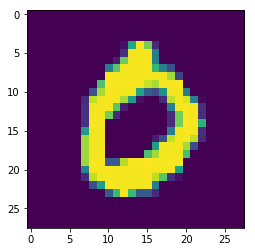

Prediction: 0


In [8]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

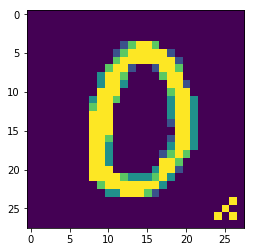

Prediction: 1

 Effectiveness of poison: 94.38%


In [9]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))


In [10]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\n Overall test set accuracy (i.e. effectiveness of poison): %.2f%%" % (total_acc * 100))



 Overall test set accuracy (i.e. effectiveness of poison): 95.63%


In [11]:
defence = ActivationDefence(classifier, x_train, y_train)

In [18]:
confidence_level, is_clean_lst = defence.detect_poison(n_clusters=2,
                                                       ndims=10,
                                                       reduce="PCA")
print("Analysis completed")

Analysis completed


In [19]:
# Evaluate method when ground truth is known:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
confusion_matrix = defence.evaluate_defence(is_clean)
import pprint
import json
pp = pprint.PrettyPrinter(indent=10)


jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 

------------------- Results using size metric -------------------
class_2
{u'FalseNegative': {u'denominator': 363, u'numerator': 0, u'rate': 0.0},
 u'FalsePositive': {u'denominator': 736, u'numerator': 106, u'rate': 14.4},
 u'TrueNegative': {u'denominator': 736, u'numerator': 630, u'rate': 85.6},
 u'TruePositive': {u'denominator': 363, u'numerator': 363, u'rate': 100.0}}
class_3
{u'FalseNegative': {u'denominator': 386, u'numerator': 0, u'rate': 0.0},
 u'FalsePositive': {u'denominator': 784, u'numerator': 43, u'rate': 5.48},
 u'TrueNegative': {u'denominator': 784, u'numerator': 741, u'rate': 94.52},
 u'TruePositive': {u'denominator': 386, u'numerator': 386, u'rate': 100.0}}
class_0
{u'FalseNegative': {u'denominator': 384, u'numerator': 0, u'rate': 0.0},
 u'FalsePositive': {u'denominator': 779, u'numerator': 4, u'rate': 0.51},
 u'TrueNegative': {u'denominator': 779, u'numerator': 775, u'rate': 99.49},
 u'TruePositive': {u'denominator': 384, u'numerator': 384, u'rate': 100.0}}
class_1
{u'

# Activation Clustering

In the case of unaltered data from the target class, the classifier identifies features in the input that it has learned correspond to the target class.  In the case of backdoor samples, it identifies features associated with the source class and the backdoor trigger, which causes it to classify the input as the target class.  This difference in mechanisms should be evident in the network activations, which represent how the network makes its "decisions".

In the case of Activation clustering for detecting poisoned data, a neural network is trained using untrusted data that potentially contains poisonous samples.  The activations of the last hidden layer are retained.  Analyzing the activations of the last hidden layer has been shown to be enough to detect poison.

Intuitively, this is believed to make sense because the early layers correspond to "low-level" features that are less likely to be indicative of poisonous data and may only add noise to the analysis.

In [20]:
[clusters_by_class, _] = defence.cluster_activations()

defence.set_params(**{'ndims': 3})
[_, red_activations_by_class] = defence.cluster_activations()

Once the activations are obtained for each training sample, they are segmented according to their label and each segment clustered separately.

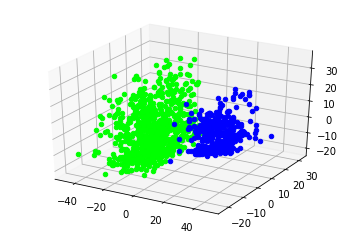

In [21]:
c=0
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])

Clusters for class 1.
Note that one of the clusters contains the poisonous data for this class.
Also, legitimate number of data points are less (see relative size of digits)


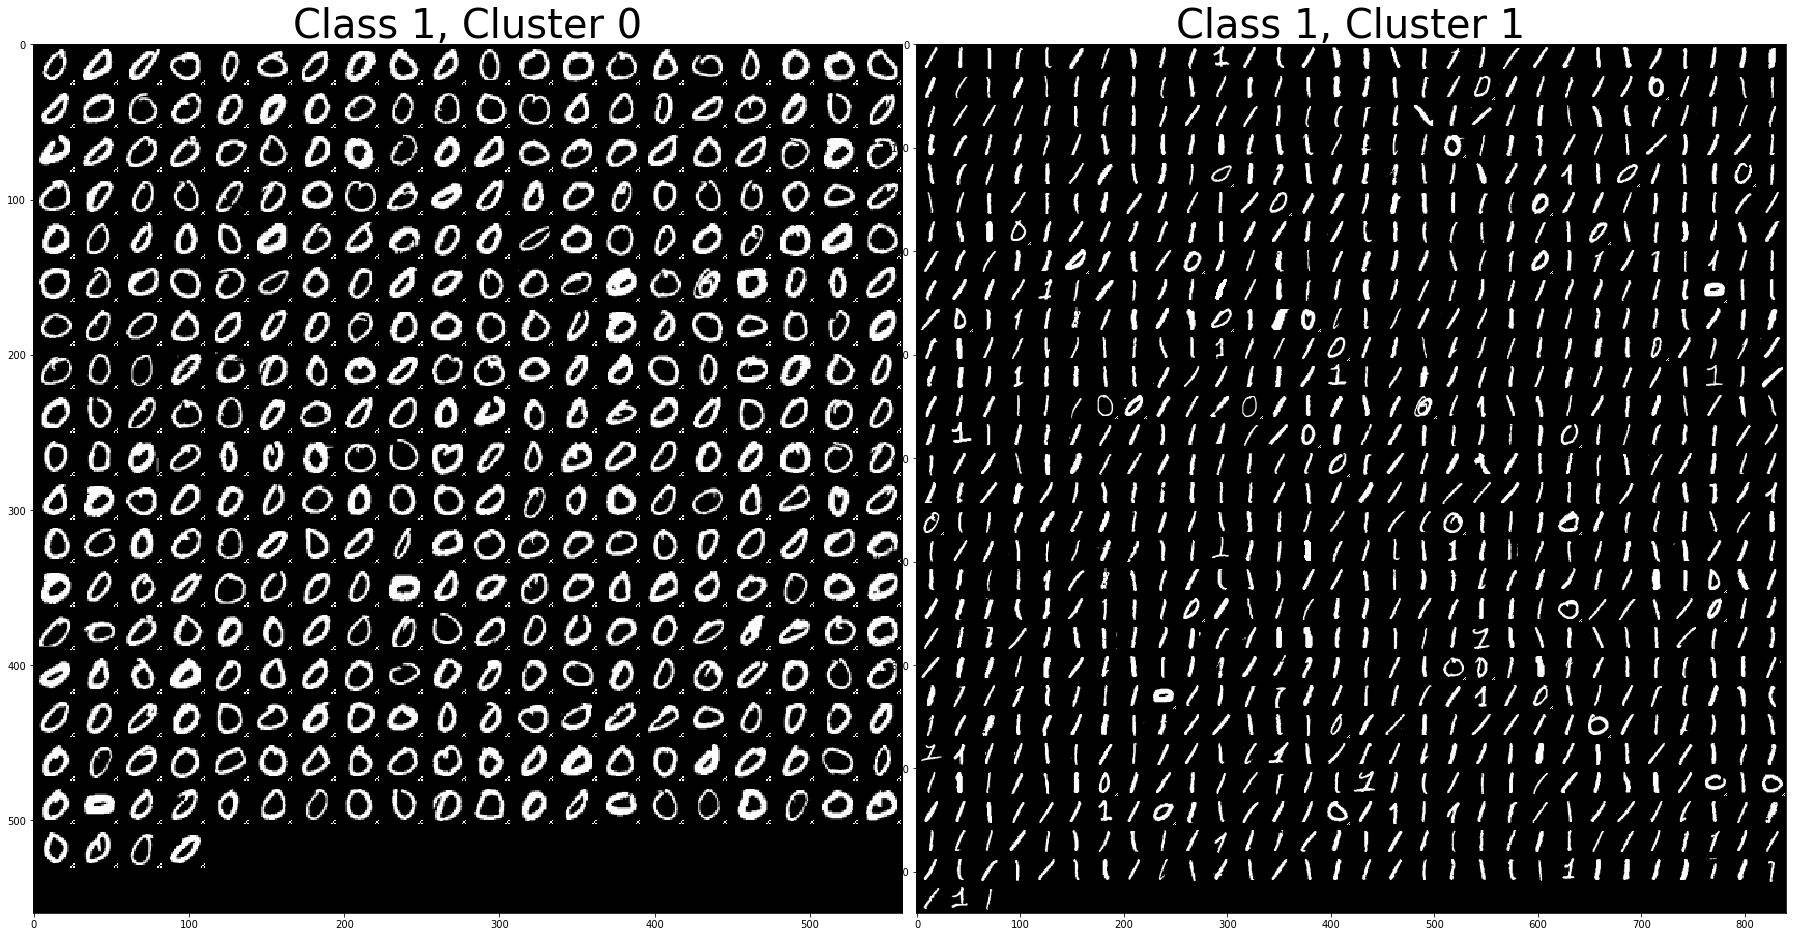

In [22]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(25,25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title("Class "+ str(n_class)+ ", Cluster "+ str(q), fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')
        
sprites_by_class = defence.visualize_clusters(x_train, save=False)

# Visualize clusters for class 1
print("Clusters for class 1.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits)")
plot_class_clusters(1, 2)

Clusters for class 5:


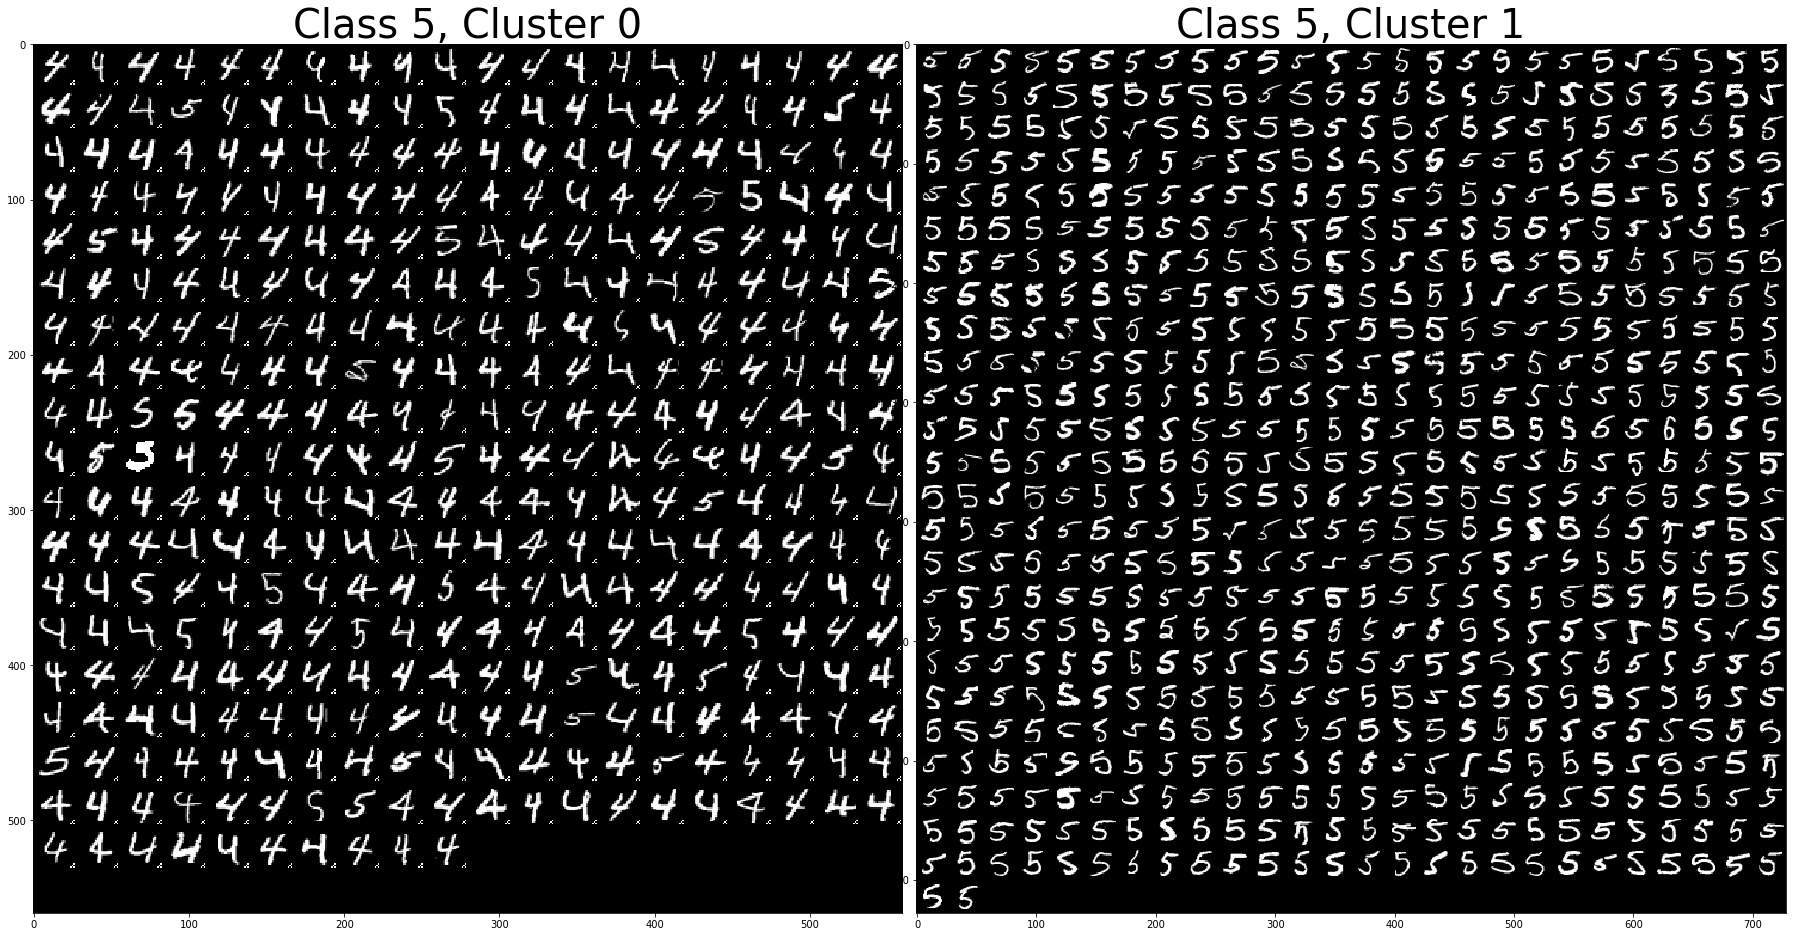

In [23]:
print("Clusters for class 5:")
plot_class_clusters(5, 2)